# **Exploratory Data Analysis**

Firstly, let's load the required libraries in order to run the code.

In [1]:
# Python base libraries
import os

# Data science libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from textblob import Word
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import plotly.express as px

# Custom libraries
from src.utils import load_json
from src.data_preprocessing import preprocess_text, filter_words_by_frequency

## Load dataset

Let's load the data, which is stored in a `JSON` file under the `data` folder.

In [2]:
# Load data
filepath = os.path.join("data", "Sarcasm_Headlines_Dataset_v2.json")
data = list(load_json(filepath))

# Show first 5 rows
data[:5]

[{'is_sarcastic': 1,
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'},
 {'is_sarcastic': 0,
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'},
 {'is_sarcastic': 0,
  'headline': 'eat your veggies: 9 deliciously different recipes',
  'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'},
 {'is_sarcastic': 1,
  'headline': 'inclement weather prevents liar from getting to work',
  'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031'},
 {'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-

We can appreciate the dataset contains a set of dictionaries, each of them containing 3 keys:

- `is_sarcastic`: 1 if the article is sarcastic, 0 otherwise.
- `headline`: the headline of the news article.
- `article_link`: link of the news article from which the sentence was extracted.

In order to be able to manipulate the data easier, we will convert the dataset into a `pandas` dataframe.

In [3]:
labels = []
headlines = []
urls = []

for item in data:
    labels.append(item["is_sarcastic"])
    headlines.append(item["headline"])
    urls.append(item["article_link"])

Let's show the first rows of each list to check they have been created correctly.

In [4]:
labels[:5]

[1, 0, 0, 1, 1]

In [5]:
headlines[:5]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly"]

In [6]:
urls[:5]

['https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205',
 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207',
 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html',
 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031',
 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546']

Let's also check they all have the same length.

In [7]:
print(len(labels))
print(len(headlines))
print(len(urls))

28619
28619
28619


Once the lists have been created, let's create the corresponding `pandas` DataFrame. Because the `urls` will not be used, we will just include both `headlines` and `urls`.

In [8]:
df = pd.DataFrame({"headline": headlines, "label": labels})
# Show first rows
df.head().style.background_gradient(cmap="YlOrRd")

,headline,label
0,thirtysomething scientists unveil doomsday clock of hair loss,1
1,"dem rep. totally nails why congress is falling short on gender, racial equality",0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting to work,1
4,mother comes pretty close to using word 'streaming' correctly,1


## Check for duplicates

Let's see if there are any duplicates in the DataFrame, so we can remove them:

In [9]:
# Number of rows duplicated
df.duplicated().sum()

116

We can see there are 116 rows duplicated, so we will remove them.

In [10]:
df.drop_duplicates(inplace=True)
df.shape

(28503, 2)

## Check datatypes and missing values

Let's now see the datatypes, as well as if there is any missing value.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28503 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  28503 non-null  object
 1   label     28503 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 668.0+ KB


It can be appreciated that:

- The headlines are stored as `object` type, which is the correct datatype.
- The labels are stored as `int64` type, which also correct.

With respect to the missing values, there are none in the dataset.

## Analyze class imbalance

One main aspect when dealing with a classification problem is class imbalance. Therefore, let's see how many rows for each class our dataset has:

In [12]:
df.groupby(by="label").agg(N=("label", "count")).style.background_gradient(cmap="YlOrRd_r")

,N
label,
0,14951
1,13552


We can appreciate there is class imbalance, in fact there are approximately around 1400 more labels corresponding to the negative class (not sarcastic articles) than the positive class (sarcastic articles).

Let's visualize this class imbalance through a barplot:

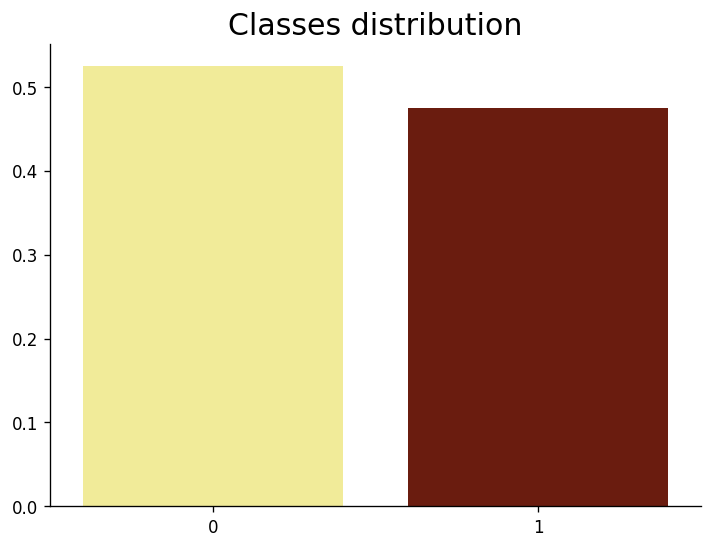

In [13]:
df_imbalance = (df.groupby(by="label").agg(N=("label", "count"))/len(df)).reset_index()

plt.figure(figsize=(7,5), dpi=120)
sns.barplot(data=df_imbalance, x=df_imbalance["label"], y=df_imbalance["N"], palette=['#FFF88B', '#791100'])
plt.title('Classes distribution', fontsize=18)
plt.xlabel("")
plt.ylabel("")
sns.despine()
plt.show()

This is something crucial to consider when training a model. When classes are imbalanced, this can lead to a model which is biased towards the class with more samples. For instance, imagine a dataset where 90% of the samples correspond to the negative class. In such scenario, a model whose accuracy is 90% might seem a pretty good model at first glance, but in reality it is not better than a model where we just predict the negative class in every case.

In those cases there are different techniques to fight class imbalance, such as:

- **Upsampling**: this technique consists in including additional samples of the minority class. This could be achieved through:
  
  + Searching for more samples of the minority class (in this case, looking for other datasets which contains similar information, or even in some cases this might mean web scraping).

  + Duplicate samples of the minority class. This is not ideal because does not give new information to the model.
  
  + Create synthetic samples of the minority class.

- **Downsampling**: this technique consists in reducing the number of samples of the majority class. This option is specially interesting when there is enough data that removing samples from the majority class does not lead to a lack of data. However, this is not usually the case, specially with unstructured data (where models need to be trained with huge amounts of data).

In some scenarios, a combination of both options might be the best solution (for instance, when only applying upsampling might lead to a huge amount of synthetic data, which can distort the results obtained, and only applying downsampling might lead to a lack of data).

## Text preprocessing

In this subsection we will perform some text preprocessing which is tpyically performed in NLP tasks. This includes:

- Convert all text to lowercase.
- Expand contractions
- Delete punctuation marks.
- Delete numbers.
- Delete stopwords.
- Lemmatization.
- Delete words with very few occurrences

Let's first see how the dataset looks like before applying any preprocessing.

In [14]:
df["headline"].head(10)

0    thirtysomething scientists unveil doomsday clo...
1    dem rep. totally nails why congress is falling...
2    eat your veggies: 9 deliciously different recipes
3    inclement weather prevents liar from getting t...
4    mother comes pretty close to using word 'strea...
5                                 my white inheritance
6           5 ways to file your taxes with less stress
7    richard branson's global-warming donation near...
8    shadow government getting too large to meet in...
9                   lots of parents know this scenario
Name: headline, dtype: object

Load the contractions dataset

In [15]:
contractions = pd.read_csv("data/Contractions.csv", sep=";")

Initialize the stopwords and lemmatizer

In [16]:
# Download stopwords and wordnet
nltk.download("stopwords")
nltk.download("wordnet")

# Load stopwords
stop_words = stopwords.words("english")
# Create lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Apply the initial preprocessing function

In [17]:
# Preprocess text
df["headline"] = df["headline"].apply(lambda x: preprocess_text(x, contractions, stop_words, lemmatizer))

After applying the initial preprocessing steps, let's see how the dataset looks like, so we can compare to how it was initially.

In [18]:
df["headline"].head(10)

0    thirtysomething scientist unveil doomsday cloc...
1    dem rep totally nail congress falling short ge...
2              eat veggie deliciously different recipe
3         inclement weather prevents liar getting work
4    mother come pretty close using word streaming ...
5                                    white inheritance
6                               way file tax le stress
7    richard bransons globalwarming donation nearly...
8    shadow government getting large meet marriott ...
9                             lot parent know scenario
Name: headline, dtype: object

# Frequency Distribution

In [19]:
# Get the number of occurrences of every word in the dataset
words = pd.Series(" ".join(df["headline"]).split()).value_counts()
# Convert into a DataFrame
words = pd.DataFrame(words).reset_index()
# Rename columns
words.columns = ["word", "frequency"]
# Show first rows
words.head()

,word,frequency
0,trump,1794
1,new,1674
2,man,1497
3,woman,945
4,say,698


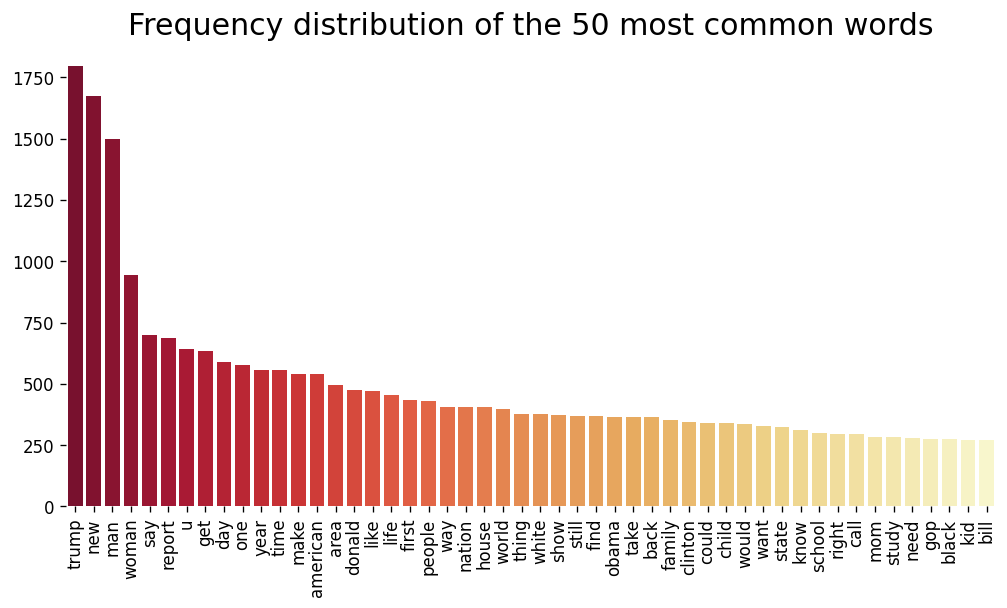

In [20]:
# Plot the frequency distribution of the 50 most common words in the dataset
plt.figure(figsize=(10,5), dpi=120)
sns.barplot(data=words.head(50), x="word", y="frequency", palette="YlOrRd_r")
plt.title('Frequency distribution of the 50 most common words', fontsize=18)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=90)
# Despine the plot
sns.despine(left=True, bottom=True)
plt.show()

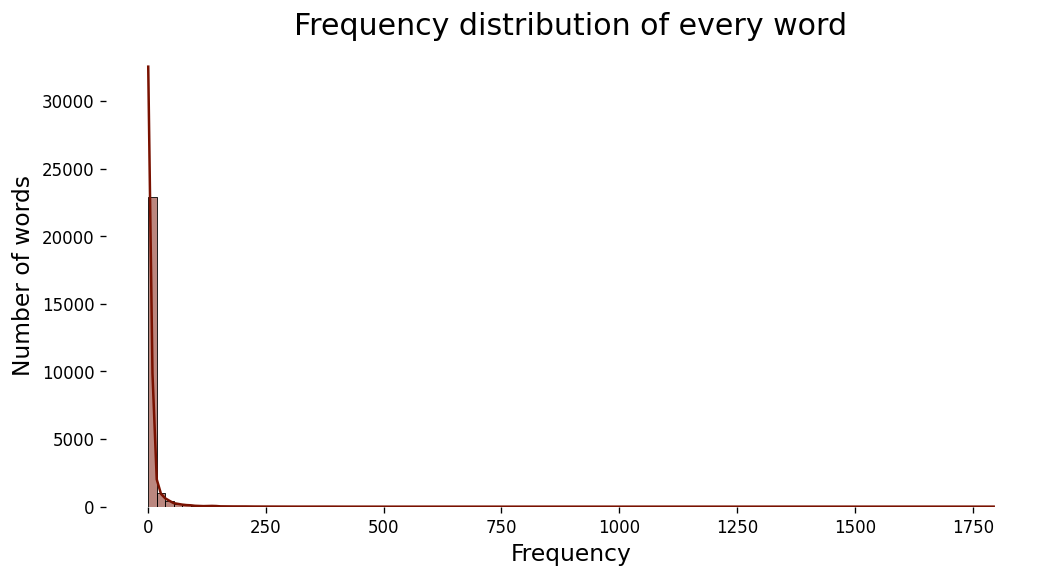

In [21]:
# Plot the frequency distribution of every word in the dataset
plt.figure(figsize=(10, 5), dpi=120)
sns.histplot(data=words, x="frequency", bins=100, kde=True, color="#791100")
plt.title("Frequency distribution of every word", fontsize=18)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Number of words", fontsize=14)
# Despine the plot
sns.despine(left=True, bottom=True)
# Remove the background color
plt.gca().set_facecolor("white")
plt.show()

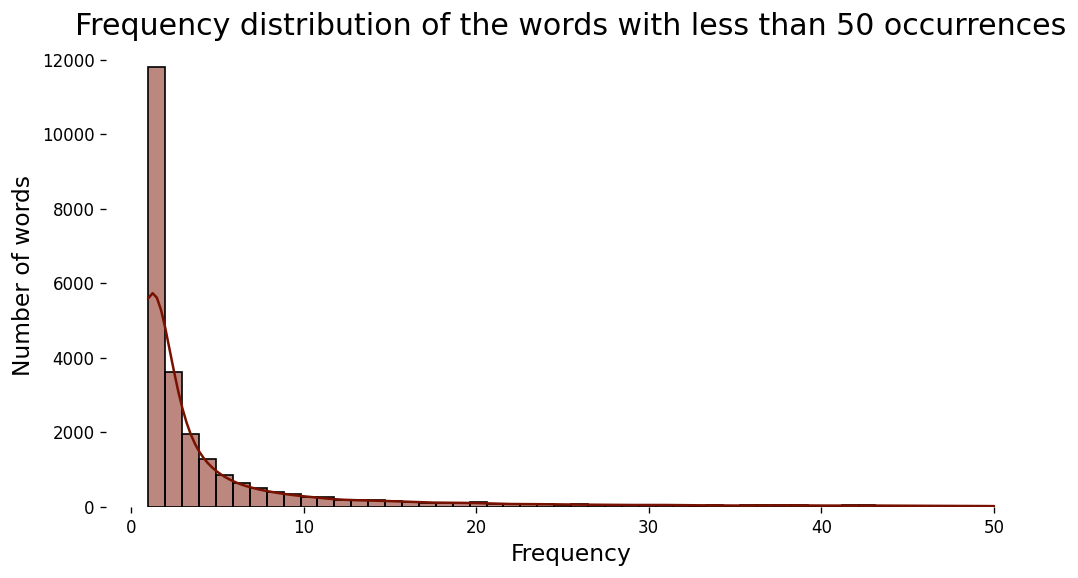

In [22]:
# Plot the frequency distribution of the words with less than 100 occurrences
plt.figure(figsize=(10, 5), dpi=120)
sns.histplot(data=words[words["frequency"] <= 50], x="frequency", bins=50, kde=True, color="#791100")
plt.title("Frequency distribution of the words with less than 50 occurrences", fontsize=18)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Number of words", fontsize=14)
# Despine the plot
sns.despine(left=True, bottom=True)
# Remove the background color
plt.gca().set_facecolor("white")
plt.show()

In [23]:
# Print the number of different words in the dataset
print(f"Number of different words in the dataset: {len(words)}")
# Create a table with the number of words with less than 10, 5, 3 and 2 occurrences
word_counts_aux = pd.DataFrame({"frequency": [10, 5, 3, 2]})
word_counts_aux["number_of_words"] = word_counts_aux["frequency"].apply(lambda x: len(words[words["frequency"] < x]))
word_counts_aux

Number of different words in the dataset: 25057


,frequency,number_of_words
0,10,21379
1,5,18655
2,3,15432
3,2,11811


The majority of words in the dataset occur very infrequently: almost half of the words appear only once (47%), and over 60% occur twice or less. This suggests that setting a threshold of 2 or 3 would remove a large number of very rare words, without sacrificing too much information. In our case, we will go for a threshold of 3.

In [24]:
# Create a dictionary with the words and their frequency for faster access
word_freq = dict(zip(words["word"], words["frequency"]))

# Apply the filter_words_by_frequency function to the "headline" column
df["headline"] = df["headline"].apply(filter_words_by_frequency, args=(word_freq,))

# Headline length distribution

In [25]:
# Get the length of every headline
df["length"] = df["headline"].apply(lambda x: len(x.split()))
df.head()

,headline,label,length
0,scientist unveil doomsday clock hair loss,1,6
1,dem rep totally nail congress falling short ge...,0,10
2,eat different recipe,0,3
3,weather prevents liar getting work,1,5
4,mother come pretty close using word streaming ...,1,8


In [26]:
px.histogram(
    df, 
    x="length",
    height=700, 
    color='label', 
    title="Headlines Length Distribution", 
    marginal="box"
)

Drop the headlines with 2 or less elements

In [27]:
# Get the headlines with length 2 or less
short_headlines = df[df["headline"].apply(lambda x: len(x.split()) <= 2)]["headline"].unique()
# Get its length
print(f'There are {len(short_headlines)} headlines with length 2 or less.')
# Drop the headlines with length 1 or 2
df = df[~df["headline"].isin(short_headlines)]

There are 1374 headlines with length 2 or less.


Drop headlines with 20 or more

In [28]:
# Get the headlines with length 20 or more
long_headlines = df[df["headline"].apply(lambda x: len(x.split()) >= 15)]["headline"].unique()
# Get its length
print(f'There are {len(long_headlines)} headlines with length 20 or more.')
# Drop the headlines with length 20 or more
df = df[~df["headline"].isin(long_headlines)]

There are 26 headlines with length 20 or more.


Let's save the preprocessed dataset into a `CSV` file, so we can use it in following notebooks. Before doing so, we'll remove the empty rows

In [29]:
# Remove the empty rows and keep only the headlines, labels columns
df = df[df["headline"] != ""]
df = df[["headline", "label"]]

# Show first rows
df.head()

,headline,label
0,scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short ge...,0
2,eat different recipe,0
3,weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


In [30]:
# Print the final headline length
print(f"Number of rows: {df.shape[0]}")

Number of rows: 27005


Finally, let's save the DataFrame into a `CSV` file.

In [31]:
# Specify path
csv_path = os.path.join("data", "Sarcasm_Headlines_Dataset_v2.csv") 
# Save DataFrame as CSV
df.to_csv(csv_path, sep=";", index=False)

# Word cloud

It might be interesting to see the most frequent words in the dataset. This can help us have a first intuition of which topics are more frequent in the dataset. For doing so, we will plot a word cloud, which is a visualization commonly used in NLP tasks.

In [32]:
all_text = " ".join([i for i in df["headline"]])
len(all_text)

1176396

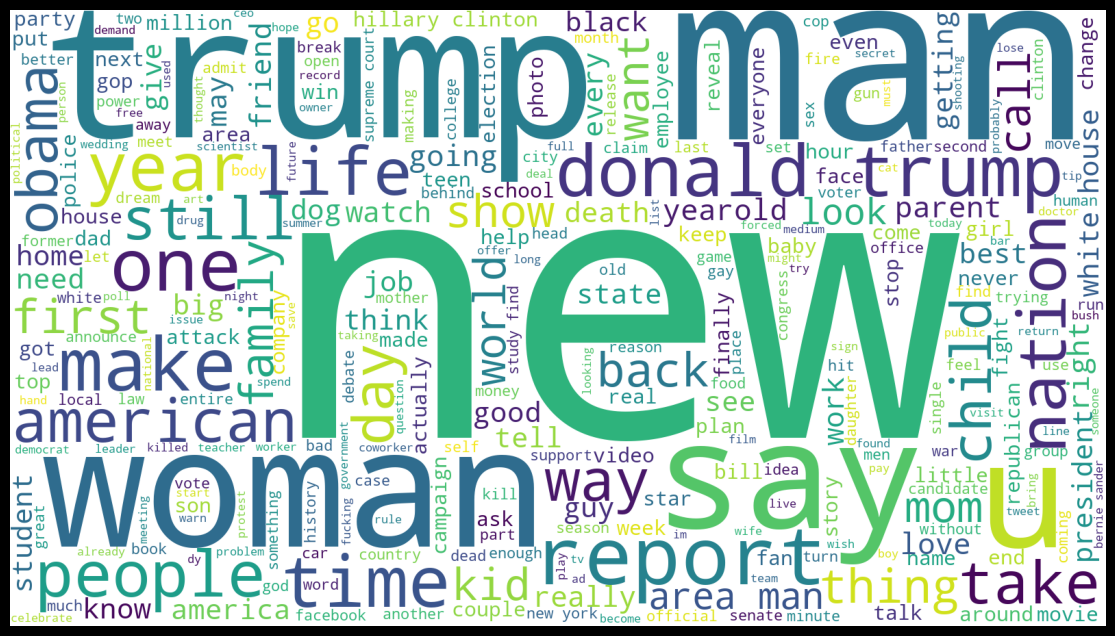

In [33]:
wc = WordCloud(
    background_color="white",
    width=1600,
    height=900,
    max_words=300, 
    contour_width=3, 
    contour_color='steelblue'
)

wc.generate(all_text)

plt.figure(figsize=(15, 8), facecolor='k')
plt.imshow(wc)
plt.axis("off")
plt.show()

As it can be seen, some of the most frequent words include:

- `american`: we expected to have news mostly from US, which explains why this word is so frequent. 
- `trump` and `donald trump`: this is not surprising, since US news mention the ex-president quite often. Moreover, we expect that Trump will be specially mentioned in sarcastic articles, since he is a controversial figure.
- `man` and `woman`
- `year`
- `time`
- `life`
- `nation`

Lastly, let's check if the words present in sarcastic and non-sarcastic titles are different

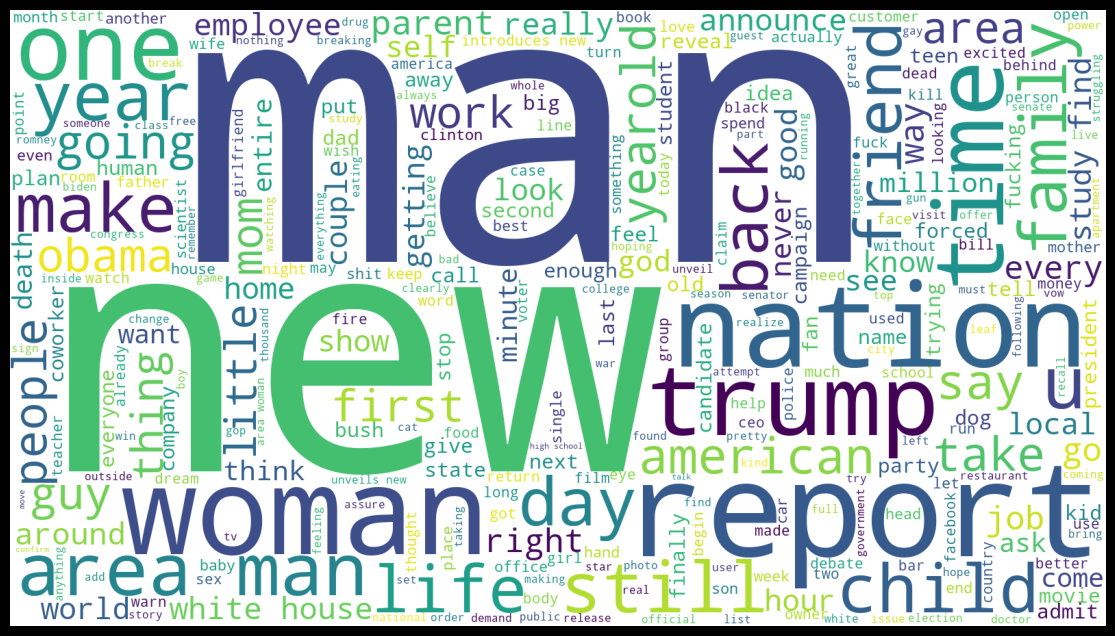

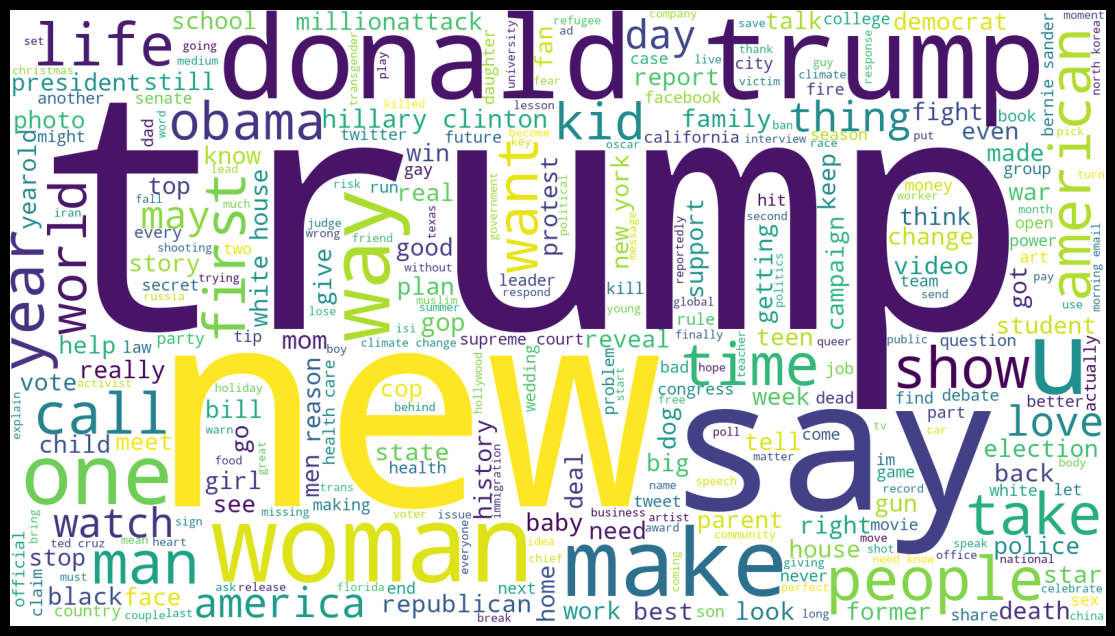

In [34]:
# Get the text of sarcastic headlines
sarcastic_text = " ".join([i for i in df[df["label"] == 1]["headline"]])

# Get the text of non-sarcastic headlines
non_sarcastic_text = " ".join([i for i in df[df["label"] == 0]["headline"]])

# Create the wordclouds
wc_sarcastic = WordCloud(
    background_color="white",
    width=1600,
    height=900,
    max_words=300,
    contour_width=3,
    contour_color='steelblue'
)

wc_non_sarcastic = WordCloud(
    background_color="white",
    width=1600,
    height=900,
    max_words=300,
    contour_width=3,
    contour_color='steelblue'
)

# Generate the wordclouds
wc_sarcastic.generate(sarcastic_text)
wc_non_sarcastic.generate(non_sarcastic_text)

# Plot the wordclouds
plt.figure(figsize=(15, 8), facecolor='k')
plt.imshow(wc_sarcastic)
plt.axis("off")
plt.show()

plt.figure(figsize=(15, 8), facecolor='k')
plt.imshow(wc_non_sarcastic)
plt.axis("off")
plt.show()

Although there are some common words between the two categories, such as `new`, `man`, or `woman`, the primary distinguishing factor between them is Donald Trump. As a highly controversial figure, he has been the subject of many more sarcastic than non-sarcastic articles.